In [1]:
# 这是关于第二章classfication 的一个回顾
# 导入需要的包
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame,Series

In [2]:
# 导入需要的数据
import tensorflow.examples.tutorials.mnist.input_data as input_data
mnist=input_data.read_data_sets('MNIST')

Extracting MNIST\train-images-idx3-ubyte.gz
Extracting MNIST\train-labels-idx1-ubyte.gz
Extracting MNIST\t10k-images-idx3-ubyte.gz
Extracting MNIST\t10k-labels-idx1-ubyte.gz


In [3]:
# 划分测试集和训练集
X_train=mnist.train.images
y_train=mnist.train.labels
X_test=mnist.test.images
y_test=mnist.test.labels

In [4]:
X_train.shape

(55000, 784)

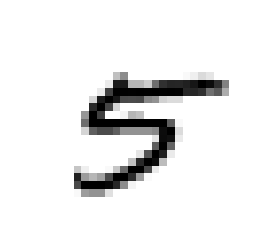

In [5]:
import matplotlib.pyplot as plt
import matplotlib
some_digit=X_train[36000]
some_digit_plot=some_digit.reshape(28,28)
plt.imshow(some_digit_plot,cmap=matplotlib.cm.binary,interpolation='nearest')
plt.axis('off') # 控制坐标轴是否显示
plt.show()
plt.close()

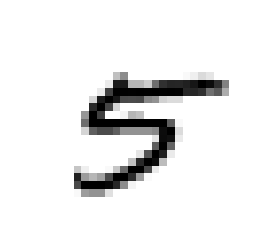

In [6]:
# 上面的可以写成一个函数
def plot_digit(data):
   datare=data.reshape(28,28)
   plt.imshow(datare,cmap=matplotlib.cm.binary,interpolation='nearest')
   plt.axis('off')
   plt.show()
   plt.close()
plot_digit(X_train[36000])    

In [7]:
# 绘制多个图像
# 一行数据有789个点，可以转换成一个28*28的图像，那么一行图像就需要28*280个点，一行画10个图
# 那么如果一行不是10个图怎么办，就需要我们来补充0，补充空白图像
# 这里需要使用两个np.concatenate来对数据进行转化
def plot_digits(datas,per_row_num=10):
    size=28
    images=[]
    for data in datas:
        redata=data.reshape(28,28)
        images.append(redata)
    # data_rownums=min(len(datas),per_row_num) # 这个是原作者的一个，当数据行数少于10行时，就启用这个
    # 这段将每行数据转换为28*28的一个像素点，并且将其添加到images这个list之中    
    data_rownums=len(datas)
    rownums=data_rownums//per_row_num + 1 # 这里加1是因为下面要计算有多少个空格
    nempty=rownums*per_row_num-data_rownums
    images.append(np.zeros((size,size*nempty)))
    # 现在images中包含了每一个字体图像和空白图像
    image=[]
    for rownum in range(rownums):
        rimages=images[rownum*per_row_num:(rownum+1)*per_row_num]  # 把10个28*28转化为一个28*280像素点
        image.append(np.concatenate(rimages,axis=1)) # 转化为6*28*280的三维数组
    image_end=np.concatenate(image,axis=0) # 组合成一个168*280 的二维数组 这个数值仅仅是针对下面这个例子
    plt.imshow(image_end,cmap=plt.cm.binary)
    plt.axis('off')
    plt.show()
    plt.close()     

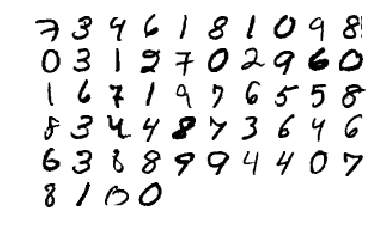

In [8]:
some_digits=X_train[:54,:]
plot_digits(some_digits)

In [9]:
# 混淆一些训练集
index=np.random.permutation(55000)
X_train,y_train=X_train[index],y_train[index]

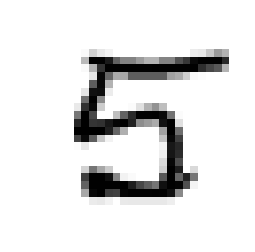

In [10]:
# 确认一下是不是一一对应
plot_digit(X_train[34000])

In [11]:
y_train[34000]

5

# 二分类问题 

In [12]:
# 我们从二分类问题开始
y_train_5=(y_train==5)
y_test_5=(y_test==5)

In [13]:
# 开始做模型
from sklearn.linear_model import SGDClassifier
sgd_clf=SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [14]:
# 做预测--预测是否为5，发现确实是
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

In [15]:
# 现在千万不能直接上测试集，记住测试集放在最后使用
# 交叉验证下
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,scoring='accuracy',cv=3)

array([ 0.96743755,  0.96099929,  0.95025364])

In [16]:
# 当然这里也能手动写交叉验证函数
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfold=StratifiedKFold(n_splits=3,random_state=42)
sgdc_clone=clone(sgd_clf)
for trainix,testix in skfold.split(X_train,y_train_5):
    x_fold_train=X_train[trainix]
    y_fold_train=y_train_5[trainix]
    x_fold_test=X_train[testix]
    y_fold_test=y_train_5[testix]
    sgdc_clone.fit(x_fold_train,y_fold_train)
    y_fold_predict=sgdc_clone.predict(x_fold_test)
    print((y_fold_predict==y_fold_test).sum()/(len(y_fold_test)))

0.967437547726
0.960999290896
0.950253640975


In [17]:
# 可以发现交叉验证的结果比较好，但是实际上效果真的这么好吗
# 构建一个estimator
from sklearn.base import BaseEstimator
class NotFiveEstimator(BaseEstimator):
    def fit(self,X,y):
        return self
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool) # 意思就是不论输入是什么，全部预测为False,即全不是5
notfiveest=NotFiveEstimator()
cross_val_score(notfiveest,X_train,y_train_5,scoring='accuracy',cv=3)  
# 可以看到，即使全部判断为False,准确率依然非常之高，所以需要使用其他的判断指标来进行判断

array([ 0.90809425,  0.90918017,  0.91070747])

In [18]:
# precision,recall,f1
from sklearn.model_selection import cross_val_predict
y_fold_predict=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

In [19]:
# 然后引入一个混淆矩阵
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_fold_predict)

array([[48748,  1265],
       [  959,  4028]], dtype=int64)

In [20]:
# precision--预测真有多少为真实真
from sklearn.metrics import precision_score
precision_score(y_train_5,y_fold_predict)

0.76100510107689401

In [21]:
# recall-- 真实真中有多少被预测为真
from sklearn.metrics import recall_score
recall_score(y_train_5,y_fold_predict)

0.80770002005213559

In [22]:
# fl score 
from sklearn.metrics import f1_score
f1_score(y_train_5,y_fold_predict)

0.78365758754863823

### 对于分类算法而言，都是先计算出decision_function的值，然后把decision_function的值和threshold进行比较，所以调整不同的threshold 将会得到不同的分类结果，好比SVM是计算出值后与0进行比较

In [23]:
y_score=sgd_clf.decision_function([some_digit])
y_score

array([ 5.96299439])

### 当我们把threshold 设置为0时，这时得到的结果就是为TRUE，当我们把threshold 设置为6时，这时就得到结果为FALSE。

In [24]:
# 进入下一个主题，如何选择合适的threshold，来使得recall和precision 为我们想要的值
y_scores= cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method='decision_function')

#### 这里注意一点就是，在cross_val_predict中选用method 为decison_function,返回结果为2列的数据，第1列全为0，第二列才是decision_function

In [25]:
y_scores=y_scores[:,1]

### 这里引入一个cruve曲线的概念

In [26]:
from sklearn.metrics import precision_recall_curve
precisions,recalls,thresholds=precision_recall_curve(y_train_5,y_scores)

In [27]:
len(precisions)

54627

In [28]:
len(recalls)

54627

In [29]:
len(thresholds) # precisions和recalls要比thresholds多一个数值，这是这个函数给出的结果
# precisions 给出的最后一位是1，recalls给出的最后一位是0

54626

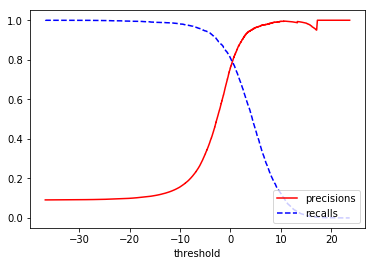

In [30]:
import matplotlib.pyplot as plt
plt.plot(thresholds,precisions[:-1],'r',label='precisions')
plt.plot(thresholds,recalls[:-1],'b--',label='recalls')
plt.xlabel('threshold')
plt.legend(loc='lower right')
plt.show()

##     通过上图就可以看到，当你需要precisions较大时，应该将threshold设置在什么位置比较好。

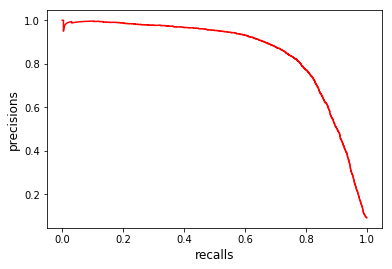

In [31]:
plt.plot(recalls,precisions,'r')
plt.xlabel('recalls',fontsize=12)
plt.ylabel('precisions',fontsize=12)
plt.show()
plt.close()

### 上图可以看出来precisions是随着recalls的增加而减少的,这里简述一下原因：recall是真实真中预测也为真的比例，当把所有的值都预测成真时（本来是假的也被预测为真），这样precisions自然就变小了
threshold越大，因为decision_function越大说明为真的可能性越大，所以剩下的预测为真的真实为真的可能性也就极大了那么整体的precision就会变大，接近1，这是真实真中预测为假也会越来越多，recall变为0

# ROC CURVE ROC曲线
这是另外一种选择合适的threshold的曲线

In [44]:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds=roc_curve(y_train_5,y_scores)

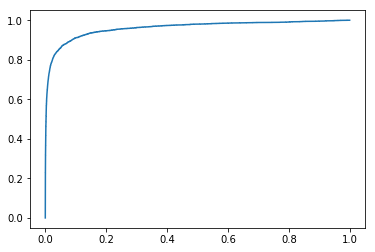

In [45]:
plt.plot(fpr,tpr)
plt.show()
plt.close()

## 这条曲线就是ROC曲线，横坐标为fpr,纵坐标为tpr,当fpr越小，tpr越大越好，即是（0,1）这个点是最好的，全部分类正确，所以越靠近（0,1）越好,曲线下的面积，代表在某个特定的模型下，变换threshold时fpr和tpr曲线围成的面积，面积越大，代表模型越好。

In [34]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores) # 代表围成的面积

0.96091880759087644

In [40]:
# 使用随机森林来做分类
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(random_state=42)
y_predict_rf=cross_val_predict(rfc,X_train,y_train_5,cv=3,method='predict_proba')
y_predict_rf=y_predict_rf[:,1]

In [43]:
# 来显示下ROC曲线
fpr_rf,tpr_rf,thresholds_rf=roc_curve(y_train_5,y_predict_rf)

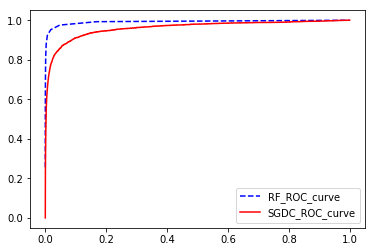

In [48]:
plt.plot(fpr_rf,tpr_rf,'b--',label='RF_ROC_curve')
plt.plot(fpr,tpr,'r',label='SGDC_ROC_curve')
plt.legend(loc='lower right')
plt.show()
plt.close()

### 可以看到randomFOREST的效果要比SGDC好的多

In [49]:
roc_auc_score(y_train_5,y_predict_rf) # 要比sgdc好

0.99229686545785245

# Multiclass classfication 多类分类问题

In [50]:
sgd_clf.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [52]:
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

## 我们看看decision_function，来看看他是怎么判断是如何确定分类的

In [55]:
some_digit_scores=sgd_clf.decision_function([some_digit]) 

In [56]:
sgd_clf.classes_[np.argmax(some_digit_scores)] # 基本的判断依据，当某类的scores越大时，就越将其判断成改类

5

In [59]:
from sklearn.multiclass import OneVsOneClassifier
ovoclf=OneVsOneClassifier(SGDClassifier(random_state=42))
ovoclf.fit(X_train,y_train)
ovoclf.predict([some_digit])

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


array([5], dtype=uint8)

In [66]:
ovoclf.decision_function([some_digit])

array([[ 2.91172289,  0.81375157,  3.89097281,  3.94107762,  7.07438272,
         9.5       ,  0.78458167,  6.09603206,  5.00420467,  4.98327399]])

## OneVsOneClassifier,ovo处理方法实际上就是将数据集划分为0/1,0/2,0/3....8/9,然后将需要预测的值带入每一个分类器之中，分为哪类的数量最多，结果就是哪类。

In [70]:
len(ovoclf.estimators_) # 一共有45个分类器

45